# ML-Lecture 4.1

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys

# or wherever you have saved the repo
sys.path.append('/Users/tlee010/Desktop/github_repos/fastai/')

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

### Discussion of combining Models

- Discussing the kaggle competition
- talking about strategies for improving scores, or improving top scoring kernels

### Some Strategies

- **Average of different models** (e.g. RF + GBM)
    - Doesn't work if one model is much worse than the other model
    - other approach, the original group means model - calculate residuals
    - then subtract the originals or divide by the original, and then use that as the target
- **Multiplying different models**: if the 2nd model targets teh ratio, you can predict the future ratios and then multiply the y_ratio vs. the y_answers
- Why does averaging works? 

### Illustration: Trees (in RF)

Each tree makes a prediction on a different set of data. With a large number of trees, ideally hoping that the sum of residuals will net to 0. This is also assuming that all the trees are comparably good systems.

## Summary : What do we know about Random Forest?

#### Minimum
1. Data you put in, needs to be numeric (convert dates to numbers)
2. Strings into -> Categorical variables then into codes
3. Missing values

#### Best practices
4. Validation sets (not always a random sample)
5. Know your metric (and optimize accordingly)
6. Validation error based on the metric 

### Key Hyperparameters, make trees less good, but generalization improves
7. Subsampling (`rf_samples`)
8. Min_samples_leaf - limits when new leafs are made by setting a minimum point
9. Max_features - 0.5 - choose random sample of features per split

## Subsampling into different trees
![](https://i0.wp.com/dimensionless.in/wp-content/uploads/RandomForest_blog_files/figure-html/voting.png?w=1080&ssl=1)

##### Tree Size
If we have a large dataset, and we subset a dataset 20k. If we make a full tree (1 end node per row), then it will be log_2(20,000) deep. There are 20k leaf nodes. All the time of effort is usually put into the last layer of the random forest tree.

##### Can you have more than 1 record in a node?
If all the deciding variables are the same for more than 1 row, you would expect to have more than one row in one leaf.

##### Information Gain
We are trying to improve RMSE, or cross_entropy, whatever your loss function / scoring function, the 'improvement' is called information gain.

#### Repeat this process X times, for different subsets of 20k, each will be associated with its own trees

- Each tree has less levels (than overall)
- less nodes (less leafs ~ 20k instead of mil)
- Each tree is considered 'weak' because it is very good at its own subset

#### Two considerations for better Random Forests
- Each tree should be better
- between the trees, they should be less correlated. Otherwise the averaging effect will not reduce the error overall

## Min_leaf_samples

##### If min leave samples = 2, what's the number of leaf nodes? (half)

##### If min leave samples = 2, what's the depth? log_2(20,000) - 1

#### Less trees, less processing, and better tree

#### HyperParameter

The parameters of a model are the actual values of the model. The actual data of the columns and Y. Hyper parameters are part of how we create the model. So an example would be processing iterations, or number of layers in a network etc. These help setup a model, but are not intrinsic to the observed data set.



## Max Features 

Max features will increase the randomness first. Withholding certain features will also prevent specific dominant features for prevailing over the tree. 


## Recapping Lesson1-RF

**n_jobs** - how many threads will be used on the random forest algorithm

**oob** - Everything that wasn't in the sample, pull that out and use that to calculate the score. With multiple iterations, this serves as a validation set, and with enough subsets, all the rows should be eventually tested.

![](https://image.slidesharecdn.com/rfbrighttalk-140522173736-phpapp02/95/building-random-forest-at-scale-20-638.jpg?cb=1485457828)

**oob as an indicator**
- if oob goes down, and validation goes down, that means overfitting
- if oob is fine, but validation goes down, then only the training dataset was affected. (When intermediate features were calculated and maybe were not applied to the training set)

** if you had 1 tree, with no replacement**

**if you have few trees, some rows may not be pulled for the oob samples**

**be careful of large datasets and oob (since the non-sample dataset may be huge)**


## Sample Sizes

**target a subset so that data will run very fast**

- small enough that you can run in reasonable amount of time
- million+ use subsamples
- 100k don't use it


## Beyond Predictions - Confidence Intervals

Many times, we actually need to take an action. We need to retain customers, we need to figure out which accounts are high risk

#### Load Data

In [2]:
# loading the data (large)
#%time df_raw = pd.read_csv('/Users/tlee010/kaggle/bulldozers/Train.csv', low_memory=False, parse_dates=["saledate"])
# print('load complete')

#### Transform the data for modeling

In [3]:
# %%time
# train_cats(df_raw)
# add_datepart(df_raw, 'saledate')
# df_raw.saleYear.head()
# df_raw.SalePrice = np.log(df_raw.SalePrice)

#### Save for later

In [5]:
# df_raw.to_feather('/Users/tlee010/kaggle/bulldozers/bulldozers-raw')

In [6]:
import feather
df_raw = feather.read_dataframe('/Users/tlee010/kaggle/bulldozers/bulldozers-raw')
print('import complete')

import complete


### Split and prep training sets

In [7]:
df_trn, y_trn, _ = proc_df(df_raw, 'SalePrice')

def split_vals(a,n): return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)


### Setup our evaluation metrics

In [8]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [9]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


# Confidence based on tree variance

#### Recap: Feature importance - very key for finding top features

- **Few features have most of the importance:** Find only the feature importances over a certain threshold
- **Collinearity distributes importance:** random forests deal with collinearity very well, but one by-product is that collinear fields will 'steal' importance. The total importance will be distributed between the column.
- **Feature filtering will consolidate importance:** Feature importance filtering and recalculating will reconsolidate importance in the key fields
- We can also loop an shuffle columns and compare the performance with the column shuffled. It's a good indicator for finding important features.

### What if instead of shuffling approach. We built a tree with a single variable at a time, then measuring importance? 

We would be missing out on interaction across multiple variables if we only looked at a single field at a time.

### Feature Importance on the bulldozer set

In [10]:
set_rf_samples(50000)

In [11]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20623327298398003, 0.24961117609288094, 0.91111012519736112, 0.88873052803450858, 0.89402299448247191]


In [12]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.28 s, sys: 6.18 ms, total: 1.28 s
Wall time: 1.28 s


(9.262686293835575, 0.28751287842978079)

In [13]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 66.6 ms, sys: 55.9 ms, total: 123 ms
Wall time: 415 ms


(9.262686293835575, 0.28751287842978079)

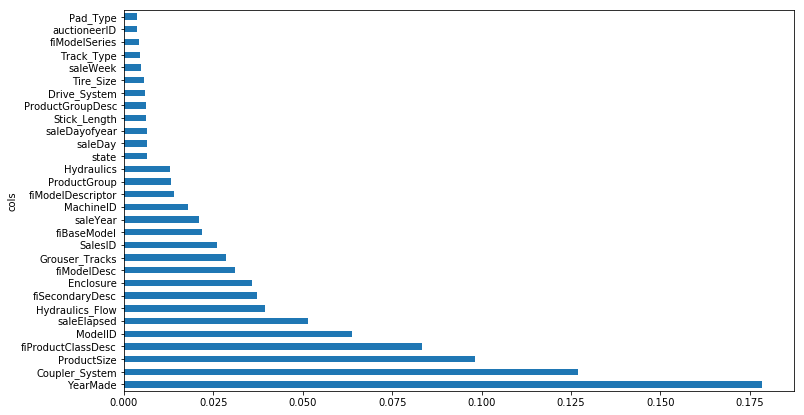

In [14]:
fi = rf_feat_importance(m, df_trn); fi[:10]
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

#### Keep top features

In [15]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

#### Retrain

In [16]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2069841382942022, 0.24614354845708988, 0.91046167671344647, 0.89180059105974052, 0.89411944174337954]


#### Re-examine the top features

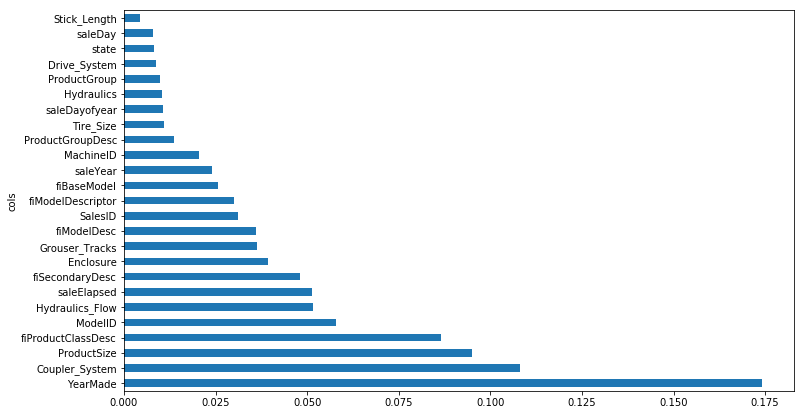

In [17]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One Hot Encoding


#### Given a single categorical field 
High = 0

Low = 1

Med = 2

To find low, you would need to a lot of splits to find 'Low'. As a field's unique fields increase, the number of splits needed to find a specific category in single column will increase dramatically. 

So instead we change them into fields. There is a trade-off between the number of fields being generated vs. how much processing you have made 

##### max_n_cat = threshold before changing to one-hot encoding

In [18]:
df_trn2, y_trn, _ = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20739388740281017, 0.2533820104194831, 0.91010682283162925, 0.8853432758769969, 0.89240567205245724]


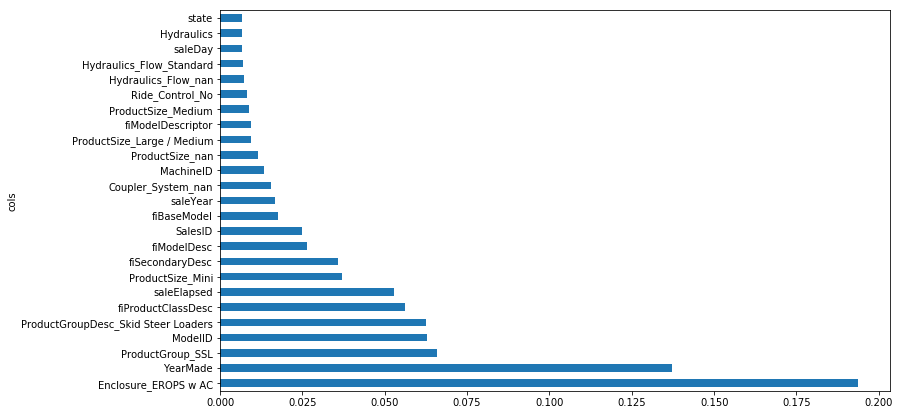

In [19]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

## How can i reduce number of columns? 

#### Spearman's R - looking at ranking vs. a field see below

Convert everything to rank, then calculate the correlation coefficient

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Spearman_fig1.svg/300px-Spearman_fig1.svg.png)


## Removing redundant features

#### Fewer things to explain

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [20]:
from scipy.cluster import hierarchy as hc

Iteratively compares columns together to see which fields are very close together. Will average them together and then compare the correlation to another field and then move up the hierarchy tree. This dendogram shows what fields may or may not be related

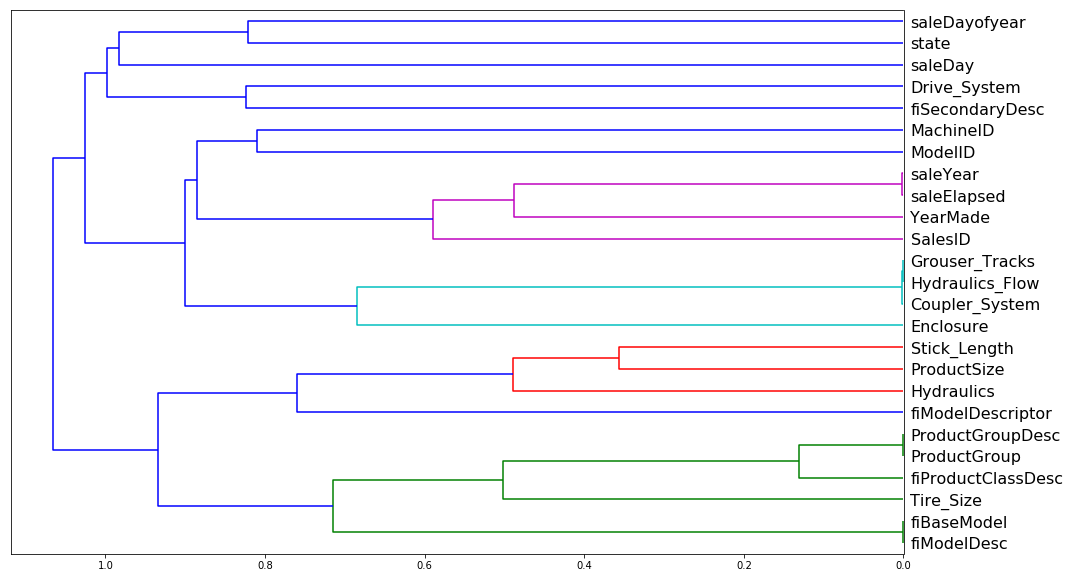

In [21]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

#### Remove each redundant columns one at a time

In [22]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

#### Baseline

In [23]:
get_oob(df_keep)

0.89010697535232319

#### Loop, but loop and remove 1 of the similar pair

In [24]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.889310279741
saleElapsed 0.887202486826
fiModelDesc 0.889103124363
fiBaseModel 0.889047474985
Grouser_Tracks 0.890271001016
Coupler_System 0.889396522484


#### Try dropping the fields

In [25]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.88902644484599391

#### Seems to work, now try on the whole dataset (for another time )

In [26]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

# Partial dependence

In [27]:
from pdpbox import pdp
from plotnine import *
import feather

In [28]:
df_raw = feather.read_dataframe('/Users/tlee010/kaggle/bulldozers/bulldozers-raw')

In [29]:
def split_vals(a,n): return a[:n], a[n:]

set_rf_samples(50000)
df_trn2, y_trn, _ = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

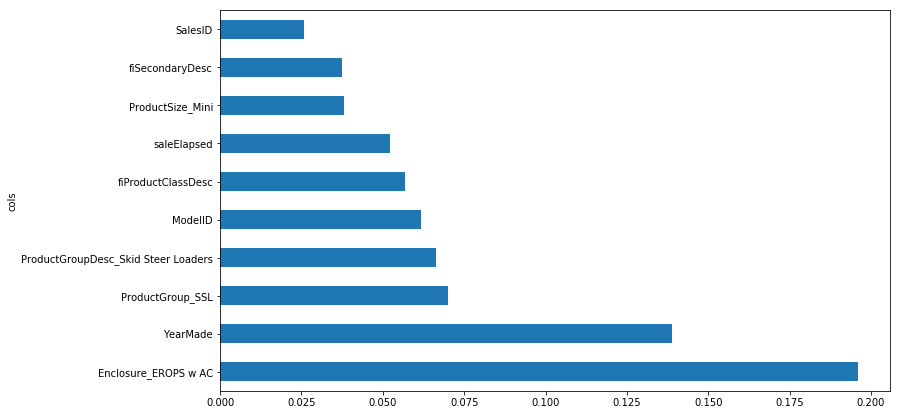

In [30]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

In [31]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [50]:
from ggplot import ggplot

In [51]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

AttributeError: 'aes' object has no attribute '_evaluate_expressions'

In [33]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [34]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

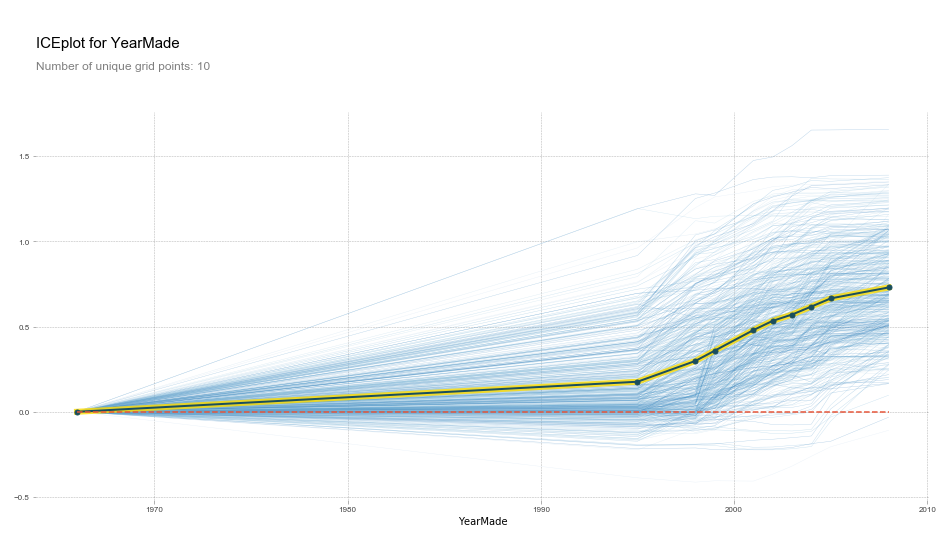

In [35]:
plot_pdp('YearMade')

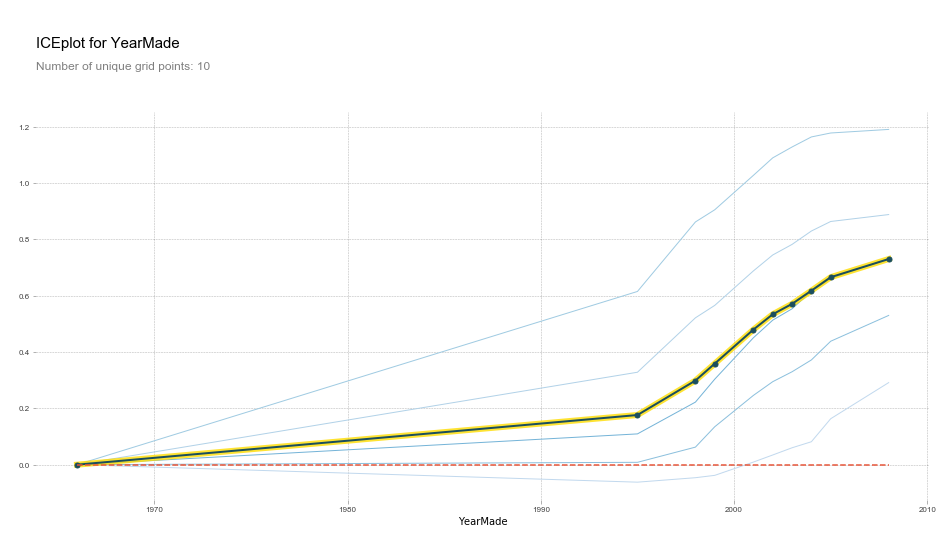

In [36]:
plot_pdp('YearMade', clusters=5)

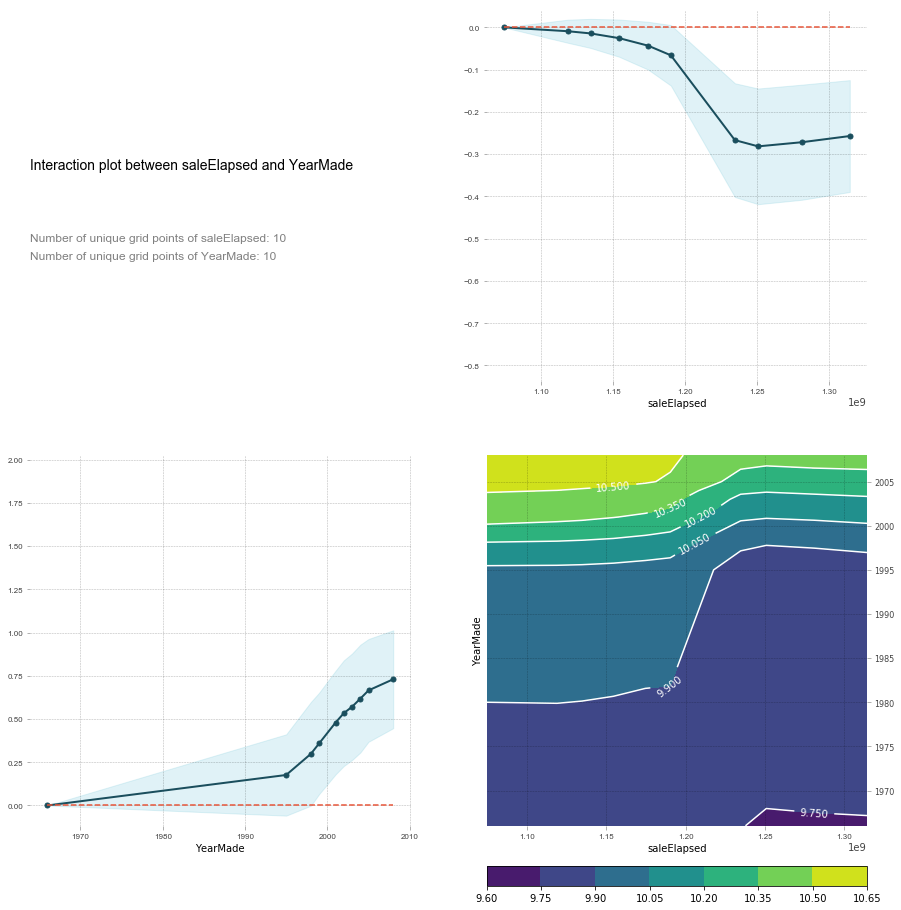

In [37]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)